In [1]:
import os
import pickle
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
image_width = 512
image_height = 512

output_folder = "output/"
work_data_folder = "data/"
ground_truth_csv_path = "data/ground_truth.csv"
detection_pickle_path = "data/detection.pkl"

for folder in [output_folder, work_data_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)


In [3]:
def read_detection_result():
    if os.path.exists(detection_pickle_path):
        detection_dfs = pickle.load(open(detection_pickle_path, 'rb'))
        return detection_dfs

    detection_result_folder = "../output/valresults/caltech/h/off"

    detection_dfs = {}
    for epoch_id in tqdm(range(51, 121), desc="test epoch"):
        folder_name = "0{}".format(epoch_id) if epoch_id < 100 else str(epoch_id)
        current_folder_path = "{}/{}".format(detection_result_folder, folder_name)
        current_folder_files = os.listdir(current_folder_path)

        detection_dfs.setdefault(epoch_id, {})
        for filename in current_folder_files:
            series_id = filename[0:-4]
            file = os.path.join(current_folder_path, filename)
            try:
                result_df = pd.read_csv(file, delimiter=" ", header=None)
                result_df.columns = ["z-index", "top_left_x", "top_left_y", "width", "height", "possibility"]
                # result_df["z_index"] = result_df['z_index'].astype('int')
            except Exception as e:
                # print(epoch_id, series_id)
                result_df = pd.DataFrame([], columns=["z-index", "top_left_x", "top_left_y", "width", "height",
                                                      "possibility"])

            detection_dfs.get(epoch_id).setdefault(series_id, result_df)

    pickle.dump(detection_dfs, open(detection_pickle_path, 'wb'))

    return detection_dfs


In [19]:
def world_to_voxel_coord(world_coord, origin, spacing):
    stretched_voxel_coord = np.absolute(world_coord - origin)
    voxel_coord = stretched_voxel_coord / spacing
    return voxel_coord


def read_ground_truth_data():
    if os.path.exists(ground_truth_csv_path):
        annotations_world_coord = pd.read_csv(ground_truth_csv_path)
        return annotations_world_coord

    annotations_path = "../downloads/annotations.csv"
    annotations_df = pd.read_csv(annotations_path, delimiter=",")
    series_uids = set(annotations_df["seriesuid"].values)

    parsed_annotations = []

    for subset_id in tqdm(range(0, 10), desc="subset"):
        download_data_folder = "../downloads/data"
        data_folder = os.listdir("{}/subset{}".format(download_data_folder, subset_id))

        for file in data_folder:
            if file.endswith(".mhd"):
                series_id = re.search(r'(.*)\.mhd', file).group(1)

                if series_id in series_uids:
                    mhd_file_path = "{}/subset{}/{}.mhd".format(download_data_folder, subset_id, series_id)
                    itk_image = sitk.ReadImage(mhd_file_path, sitk.sitkFloat32)

                    origins = np.array(list(reversed(itk_image.GetOrigin())))
                    spacings = np.array(list(reversed(itk_image.GetSpacing())))

                    current_annotations = annotations_df[annotations_df["seriesuid"] == series_id]

                    direction = itk_image.GetDirection()
                    direction = np.array(list(map(lambda x: round(x), direction)))

                    if np.any(direction != np.array([1, 0, 0, 0, 1, 0, 0, 0, 1])):
                        is_flip = True
                    else:
                        is_flip = False

                    for index, row in current_annotations.iterrows():
                        world_x = row["coordX"]
                        world_y = row["coordY"]
                        world_z = row["coordZ"]
                        d = row["diameter_mm"]

                        world_coord = np.array([float(world_z), float(world_y), float(world_x)])
                        voxel_coord = world_to_voxel_coord(world_coord, origins, spacings).astype(int)

                        voxel_z, voxel_y, voxel_x = voxel_coord
                        if is_flip:
                            voxel_x = 512 - voxel_x
                            voxel_y = 512 - voxel_y

                        diameter = int(d / spacings[2])

                        annotation = [series_id,
                                      voxel_z,
                                      max(voxel_x, 0),
                                      max(voxel_y, 0),
                                      min(voxel_x + diameter, image_width - 1),
                                      min(voxel_y + diameter, image_height - 1),
                                      ]
                        parsed_annotations.append(annotation)

    annotations_world_coord = pd.DataFrame(parsed_annotations)
    annotations_world_coord.columns = ["series_id", "z-index", "top_left_x", "top_left_y", "bottom_right_x",
                                       "bottom_right_y"]
    annotations_world_coord["width"] = annotations_world_coord["bottom_right_x"] - annotations_world_coord["top_left_x"]
    annotations_world_coord["height"] = annotations_world_coord["bottom_right_y"] - annotations_world_coord[
        "top_left_y"]
    annotations_world_coord["area"] = annotations_world_coord["width"] * annotations_world_coord["height"]
    annotations_world_coord.set_index("series_id", inplace=True)

    annotations_world_coord.to_csv(ground_truth_csv_path)
    annotations_world_coord.reset_index(inplace=True)

    return annotations_world_coord

In [12]:
detections = read_detection_result()
# detections

In [20]:
annotations = read_ground_truth_data()
annotations

,series_id,z-index,top_left_x,top_left_y,bottom_right_x,bottom_right_y,width,height,area
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,32,110,346,118,354,8,8,64
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,68,426,285,450,309,24,24,576
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,56,408,337,415,344,7,7,49
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,186,427,351,433,357,6,6,36
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,40,457,228,465,236,8,8,64
...,...,...,...,...,...,...,...,...,...
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.765459236550...,240,326,357,338,369,12,12,144
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026...,101,167,334,192,359,25,25,625
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026...,247,361,318,367,324,6,6,36
1184,1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125...,132,406,317,413,324,7,7,49


In [21]:
def compute_overlap_area_ratio(nodule, candidate):
    overlap_width = min(candidate["bottom_right_x"], nodule["bottom_right_x"]) - max(candidate["top_left_x"],
                                                                                     nodule["top_left_x"])
    if overlap_width <= 0:
        return 0
    overlap_height = min(candidate["bottom_right_y"], nodule["bottom_right_y"]) - max(candidate["top_left_y"],
                                                                                      nodule["top_left_y"])
    if overlap_height <= 0:
        return 0
    overlap_area = overlap_width * overlap_height
    total_area = candidate["area"] + nodule["area"] - overlap_area

    overlap_ratio = overlap_area / total_area
    return overlap_ratio


In [23]:
miss_rate_x = range(51, 51 + len(detections.keys()))
miss_rate_y = []

threshold = 0.5
gap = 5

for epoch in detections.keys():
    epoch_result = detections[epoch]
    number_of_test = 0
    counter = 0
    for series_id in epoch_result.keys():
        detection = epoch_result[series_id]
        detection["z-index"] = detection["z-index"].astype("int")
        detection["bottom_right_x"] = detection["top_left_x"] + detection["height"]
        detection["bottom_right_y"] = detection["top_left_y"] + detection["height"]
        detection["area"] = detection["height"] * detection["height"]
        nodules = annotations[annotations["series_id"] == series_id]

        for i, nodule in nodules.iterrows():
            nodule_z = nodule["z-index"]
            max_ratio = 0
            best_detection = -1
            best_candidate = pd.DataFrame()
            number_of_test += 1

            for j, candidate in detection[
                (detection['z-index'] >= (nodule_z - gap) & (detection['z-index'] <= (nodule_z + gap)))].iterrows():
                ratio = compute_overlap_area_ratio(nodule, candidate)
                if ratio >= threshold:
                    best_detection = j
                    best_candidate = candidate[["z-index", "top_left_x", "top_left_y", "width", "height"]]
                    max_ratio = ratio

            if best_detection != -1:
                counter += 1

            annotations.loc[i, "best_detection"] = best_detection
            annotations.loc[i, "best_candidate"] = best_candidate.to_string()
            annotations.loc[i, "best_overlap_ratio"] = max_ratio

    miss_rate = counter / number_of_test
    miss_rate_y.append(miss_rate)
    annotations[annotations["best_detection"].notnull()].to_csv("output/{}.csv".format(epoch))


In [24]:
miss_rate_y

[0.2857142857142857,
 0.29523809523809524,
 0.2761904761904762,
 0.2761904761904762,
 0.29523809523809524,
 0.29523809523809524,
 0.2857142857142857,
 0.2857142857142857,
 0.29523809523809524,
 0.2857142857142857,
 0.2761904761904762,
 0.2857142857142857,
 0.2857142857142857,
 0.29523809523809524,
 0.29523809523809524,
 0.2857142857142857,
 0.2857142857142857,
 0.26666666666666666,
 0.26666666666666666,
 0.2857142857142857,
 0.2761904761904762,
 0.2857142857142857,
 0.2857142857142857,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.3047619047619048,
 0.29523809523809524,
 0.3047619047619048,
 0.3047619047619048,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.2857142857142857,
 0.2857142857142857,
 0.2761904761904762,
 0.2761904761904762,
 0.26666666666666666,
 0.2761904761904762,
 0.29523809

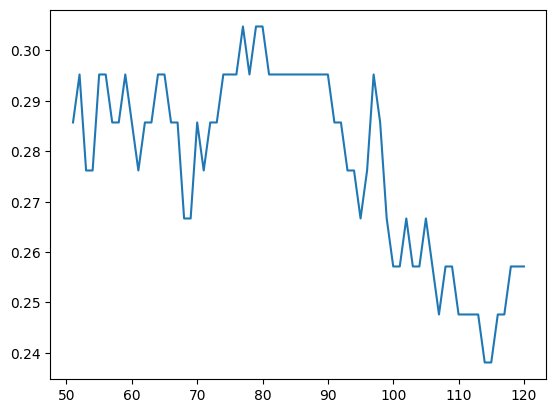

In [25]:
plt.plot(miss_rate_x, miss_rate_y, label='MR')

In [26]:
miss_rate_y

[0.2857142857142857,
 0.29523809523809524,
 0.2761904761904762,
 0.2761904761904762,
 0.29523809523809524,
 0.29523809523809524,
 0.2857142857142857,
 0.2857142857142857,
 0.29523809523809524,
 0.2857142857142857,
 0.2761904761904762,
 0.2857142857142857,
 0.2857142857142857,
 0.29523809523809524,
 0.29523809523809524,
 0.2857142857142857,
 0.2857142857142857,
 0.26666666666666666,
 0.26666666666666666,
 0.2857142857142857,
 0.2761904761904762,
 0.2857142857142857,
 0.2857142857142857,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.3047619047619048,
 0.29523809523809524,
 0.3047619047619048,
 0.3047619047619048,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.29523809523809524,
 0.2857142857142857,
 0.2857142857142857,
 0.2761904761904762,
 0.2761904761904762,
 0.26666666666666666,
 0.2761904761904762,
 0.29523809